In [239]:
import pandas as pd

In [240]:
trips_hourly = pd.read_pickle('../00_data/trips_hourly.pkl')
trips_df = pd.read_pickle('../00_data/trips.pkl')

### Create available bikes feature

In [241]:
# we calculate the total number of ongoing trips
# we can use the number of ongoing trips of the previous hour as feature,
# because our task is to predict the total demand exactly for the next hour
trips_hourly['trips_diff'] = trips_hourly['starting_trips'] - trips_hourly['ending_trips']
trips_hourly['ongoing_trips'] = trips_hourly['trips_diff'].cumsum()
# we can now use ongoing trips from the previous hour as input feature
trips_hourly['ongoing_trips_prev'] = trips_hourly['ongoing_trips'].shift(1)

In [242]:
trips_hourly.head(5)

,starting_trips,ending_trips,trips_diff,ongoing_trips,ongoing_trips_prev
2019-01-01 00:00:00,14.0,12.0,2.0,2.0,NaN
2019-01-01 01:00:00,8.0,6.0,2.0,4.0,2.0
2019-01-01 02:00:00,11.0,12.0,-1.0,3.0,4.0
2019-01-01 03:00:00,2.0,4.0,-2.0,1.0,3.0
2019-01-01 06:00:00,2.0,2.0,0.0,1.0,1.0


In [243]:
trips_hourly = trips_hourly[['starting_trips', 'ongoing_trips_prev']]
# effectively drops first observation as ongoing trips prev cannot be calculated due to the abscence of data
trips_hourly = trips_hourly.dropna()

In [244]:
# get the number of unique bike_ids per week
trips_df['week'] = trips_df['start_time'].dt.isocalendar().week

bike_ids_week_grouped = (
    trips_df.groupby(["week"])['bike_id']
    .nunique()
    .to_frame("bike_ids_week")
)
bike_ids_week_grouped.mean()

bike_ids_week    757.480769
dtype: float64

In [245]:
# create dataframe that depicts the first time and the last time each bicycle was used (in our defined timeframe)
# and the number of trips made with it
bikes_df = trips_df.groupby("bike_id").agg(
    {
		"start_time": "min",
		"end_time": "max",
		"bike_id": "count"
	}
)
# bikes_df = bikes_df.rename(columns={
#     "start_time" : "first_trip_start_time",
#     "end_time" : "last_trip_end_time",
#     "bike_id" : "number_of_trips"
# })
bikes_df.head(5)

,start_time,end_time,bike_id
bike_id,,,
5715,2019-04-17 23:39:00,2019-12-17 21:57:12,68
5716,2019-04-13 15:58:00,2019-06-07 17:13:00,33
5717,2019-04-23 07:42:00,2019-12-20 18:08:21,129
5718,2019-09-14 05:54:00,2019-12-31 15:20:23,48
5719,2019-04-15 18:26:00,2019-12-30 15:31:02,71


In [246]:
# show bikes with latest start time and earliest end time
# indicates whether bikes are available constantly or not
trips_df[(trips_df["bike_id"] == bikes_df["start_time"].idxmax())]

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,duration,start_latitude,start_longitude,end_latitude,end_longitude,distance,speed,week
290267,2019-12-31 20:50:25,2019-12-31 20:58:42,4442,4436,6130,Annual Pass,Normandie & Sunset,Vermont & Franklin,0 days 00:08:17,34.098,-118.30047,34.10578,-118.29194,1.032698,7.480307,1


In [247]:
trips_df[(trips_df["bike_id"] == bikes_df["end_time"].idxmin())]

,start_time,end_time,start_station_id,end_station_id,bike_id,user_type,start_station_name,end_station_name,duration,start_latitude,start_longitude,end_latitude,end_longitude,distance,speed,week
85,2019-01-01 11:07:00,2019-01-01 11:49:00,4210,4210,12043,Walk-up,Ocean Front Walk & North Venice,Ocean Front Walk & North Venice,0 days 00:42:00,33.98434,-118.47155,33.98434,-118.47155,0.0,0.0,1
144,2019-01-01 12:29:00,2019-01-01 12:52:00,4210,4210,12043,Walk-up,Ocean Front Walk & North Venice,Ocean Front Walk & North Venice,0 days 00:23:00,33.98434,-118.47155,33.98434,-118.47155,0.0,0.0,1


In [248]:
bikes_df["start_time_floored"] = bikes_df["start_time"].dt.floor("1H")
bikes_df["end_time_floored"] = bikes_df["end_time"].dt.floor("1H") + pd.DateOffset(hours=1)

bikes_used_after = (
    bikes_df.groupby("start_time_floored").size().to_frame("bikes_used_after")
)
bikes_used_before = (
    bikes_df.groupby("end_time_floored").size().to_frame("bikes_used_before")
)

bikes_used = pd.concat([bikes_used_before, bikes_used_after], axis=1)
bikes_used = bikes_used.fillna(0)
bikes_used['diff'] = bikes_used['bikes_used_after'] - bikes_used['bikes_used_before'] 
bikes_used['in_service_bikes'] = bikes_used['diff'].cumsum()


<AxesSubplot:xlabel='start_time_floored', ylabel='in_service_bikes'>

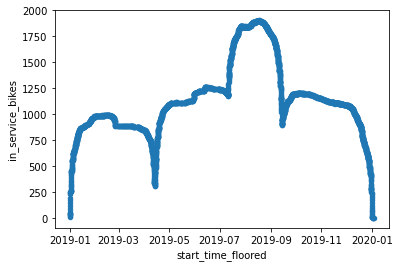

In [249]:
bikes_used = bikes_used.reset_index().rename(columns={"index": "start_time_floored"})
bikes_used.plot.scatter(x="start_time_floored", y="in_service_bikes")

In [250]:
bikes_used['in_service_bikes_rolling'] = bikes_used.rolling('30d', center=True, on='start_time_floored')['in_service_bikes'].max()

<AxesSubplot:xlabel='start_time_floored', ylabel='in_service_bikes_rolling'>

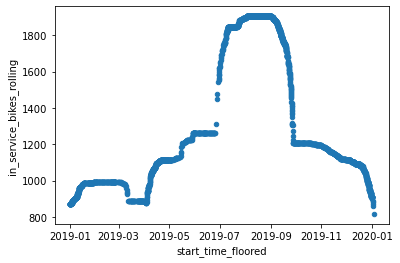

In [251]:
bikes_used.plot.scatter(x="start_time_floored", y="in_service_bikes_rolling")

In [252]:
bikes_used = bikes_used.set_index("start_time_floored")

In [253]:
bikes_used['in_service_bikes_rolling']

start_time_floored
2019-01-01 00:00:00    873.0
2019-01-01 01:00:00    873.0
2019-01-01 02:00:00    873.0
2019-01-01 03:00:00    873.0
2019-01-01 06:00:00    873.0
                       ...  
2020-01-01 17:00:00    890.0
2020-01-02 01:00:00    883.0
2020-01-02 13:00:00    872.0
2020-01-02 18:00:00    861.0
2020-01-03 16:00:00    816.0
Name: in_service_bikes_rolling, Length: 2924, dtype: float64

In [254]:
trips_hourly['in_service_bikes_rolling'] = bikes_used['in_service_bikes_rolling'].asfreq('1H', method="bfill")
trips_hourly.head(2)

,starting_trips,ongoing_trips_prev,in_service_bikes_rolling
2019-01-01 01:00:00,8.0,2.0,873.0
2019-01-01 02:00:00,11.0,4.0,873.0


In [255]:
trips_hourly["available_bikes"] = (
    trips_hourly["in_service_bikes_rolling"] - trips_hourly["ongoing_trips_prev"]
)
trips_hourly.head(2)

,starting_trips,ongoing_trips_prev,in_service_bikes_rolling,available_bikes
2019-01-01 01:00:00,8.0,2.0,873.0,871.0
2019-01-01 02:00:00,11.0,4.0,873.0,869.0


In [256]:
trips_hourly.describe()

,starting_trips,ongoing_trips_prev,in_service_bikes_rolling,available_bikes
count,8432.000000,8432.000000,8432.000000,8432.000000
mean,26.759843,10.846181,1273.419711,1262.573529
std,21.229878,10.954113,341.360424,340.364612
min,0.000000,0.000000,816.000000,815.000000
25%,7.000000,5.000000,993.000000,988.000000
50%,25.000000,9.000000,1160.000000,1151.000000
75%,41.000000,14.000000,1451.000000,1443.000000
max,281.000000,364.000000,1905.000000,1904.000000


### Add weather features

In [257]:
weather_df = pd.read_pickle('../00_data/weather.pkl')

In [258]:
weather_df = weather_df.asfreq("1H", method="ffill")
weather_df.isna().sum()

max_temp    0
min_temp    0
precip      0
dtype: int64

In [259]:
trips_hourly['max_temp'] = weather_df['max_temp']
trips_hourly['min_temp'] = weather_df['min_temp']
trips_hourly['precip'] = weather_df['precip']

trips_hourly.head(2)

,starting_trips,ongoing_trips_prev,in_service_bikes_rolling,available_bikes,max_temp,min_temp,precip
2019-01-01 01:00:00,8.0,2.0,873.0,871.0,15.6,15.6,0.0
2019-01-01 02:00:00,11.0,4.0,873.0,869.0,15.0,15.0,0.0


### Create time related features

In [260]:
# create time related features
trips_hourly['hour'] = trips_hourly.index.hour
trips_hourly['day_of_week'] = trips_hourly.index.day_of_week
trips_hourly['month'] = trips_hourly.index.month
trips_hourly['day_of_year'] = trips_hourly.index.day_of_year
trips_hourly['week'] = trips_hourly.index.isocalendar().week
trips_hourly['is_weekday'] = trips_hourly['day_of_week'] < 5
trips_hourly['date'] = trips_hourly.index.date

In [261]:
# one hot encoding of categorical features
# hour encoding
hour_dummies = pd.get_dummies(trips_hourly["hour"], prefix="hour")
trips_hourly[list(hour_dummies.columns)] = hour_dummies.astype(bool)

day_of_week_dummies = pd.get_dummies(trips_hourly["day_of_week"], prefix="day_of_week")
trips_hourly[list(day_of_week_dummies.columns)] = day_of_week_dummies.astype(bool)

month_dummies = pd.get_dummies(trips_hourly["month"], prefix="month")
trips_hourly[list(month_dummies.columns)] = month_dummies.astype(bool)

trips_hourly.columns

Index(['starting_trips', 'ongoing_trips_prev', 'in_service_bikes_rolling',
       'available_bikes', 'max_temp', 'min_temp', 'precip', 'hour',
       'day_of_week', 'month', 'day_of_year', 'week', 'is_weekday', 'date',
       'hour_0', 'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6',
       'hour_7', 'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12',
       'hour_13', 'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18',
       'hour_19', 'hour_20', 'hour_21', 'hour_22', 'hour_23', 'day_of_week_0',
       'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
       'day_of_week_5', 'day_of_week_6', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12'],
      dtype='object')

### Create is holiday feature

In [262]:
holidays_df = pd.read_pickle('../00_data/holidays.pkl')

In [263]:
print(trips_hourly['date'].dtype)
print(holidays_df['date'].dtype)

object
datetime64[ns]


In [264]:
trips_hourly['date'] = trips_hourly['date'].astype('datetime64[ns]')
trips_hourly = trips_hourly.merge(holidays_df, on='date', how='left')

In [265]:
trips_hourly['is_holiday'] = trips_hourly['holiday_name'].notna()
trips_hourly = trips_hourly.drop(columns=['holiday_name', 'date'])
trips_hourly.columns

Index(['starting_trips', 'ongoing_trips_prev', 'in_service_bikes_rolling',
       'available_bikes', 'max_temp', 'min_temp', 'precip', 'hour',
       'day_of_week', 'month', 'day_of_year', 'week', 'is_weekday', 'hour_0',
       'hour_1', 'hour_2', 'hour_3', 'hour_4', 'hour_5', 'hour_6', 'hour_7',
       'hour_8', 'hour_9', 'hour_10', 'hour_11', 'hour_12', 'hour_13',
       'hour_14', 'hour_15', 'hour_16', 'hour_17', 'hour_18', 'hour_19',
       'hour_20', 'hour_21', 'hour_22', 'hour_23', 'day_of_week_0',
       'day_of_week_1', 'day_of_week_2', 'day_of_week_3', 'day_of_week_4',
       'day_of_week_5', 'day_of_week_6', 'month_1', 'month_2', 'month_3',
       'month_4', 'month_5', 'month_6', 'month_7', 'month_8', 'month_9',
       'month_10', 'month_11', 'month_12', 'is_holiday'],
      dtype='object')

### Create number of open stations feature

In [266]:
trips_hourly.to_pickle('../00_data/trips_hourly_engineered.pkl')